# 순환 신경망(RNN)

## RNN 구현

RNN 계층 구현

In [1]:
import numpy as np

class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.matmul(h_prev, Wh) + np.matmul(x, Wx) + b ## [N,H]@[H,H] => [N,H], [N,D]@[D,H] => [N,H]
        h_next = np.tanh(t) ## [N,H]

        self.cache = (x, h_prev, h_next)
        return h_next
    
    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache

        dt = dh_next * (1 - h_next**2) ## tanh 미분, [N,H]
        db = np.sum(dt, axis=0) ## repeat는 누적, [H,]
        dWh = np.matmul(h_prev.T, dt) ## [H,N]@[N,H] => [H,H]
        dh_prev = np.matmul(dt, Wh.T) ## [N,H]@[H,H] => [N,H]
        dWx = np.matmul(x.T, dt) ## [D,N]@[N,H] => [D,H]
        dx = np.matmul(dt, Wx.T) ## [N,H]@[H,D] => [N,D]

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        return dx, dh_prev

Time RNN 계층 구현

In [2]:
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.dh = None, None
        self.stateful = stateful
    
    def set_state(self, h):
        self.h = h
    
    def reset_state(self):
        self.h = None
    
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape ## 배치, 시간, 입력 
        D, H = Wx.shape ## 입력, 히든

        self.layers = []
        hs = np.empty((N,T,H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N,H), dtype='f')

        for t in range(T):
            layer = RNN(*self.params)
            ## xs[:, t, :] -> [N,D], self.h -> [N,H]
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h ## [N,H]
            self.layers.append(layer)
        
        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape

        dxs = np.empty((N,T,D), dtype='f')
        dh = 0
        grads = [0,0,0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            ## dhs[:,t,:] -> [N,H], dh -> [N,H]
            ## dx -> [N,D], dh -> [N,H]
            dx, dh = layer.backward(dhs[:, t, :] + dh)
            dxs[:, t, :] = dx

            for i, grad in enumerate(layer.grads):
                grads[i] += grad
        
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh

        return dxs

## 시계열 데이터 처리 계층 구현

Time 계층 구현

In [3]:
class TimeAffine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None
    
    def forward(self, x, t):
        N, T, D = x.shape
        W, b = self.params

        rx = x.reshape(N*T, -1)
        out = np.dot(rx, W) + b
        self.x = x
        return out
    
    def backward(self, dout):
        x = self.x
        N, T, D = x.shape
        W, b = self.params

        dout = dout.reshape(N*T, -1)
        rx = x.reshape(N*T, -1)

        db = np.sum(dout, axis=0)
        dW = np.dot(rx.T, dout)
        dx = np.dot(dout, W.T)
        dx = dx.reshape(*x.shape)

        self.grads[0][...] = dW
        self.grads[1][...] = db
        
        return dx

## RNNLM 학습과 평가

RNNLM 구현

In [4]:
import numpy as np
from common.time_layers import *

class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V,D) / 100).astype('f')
        rnn_Wx = (rn(D,H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H,H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H,V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layers = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
    
    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layers.forward(xs, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layers.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.rnn_layer.reset_state()

RNNLM의 학습 코드

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from dataset import ptb

batch_size = 10
wordvec_size = 100
hidden_size = 100
time_size = 5
lr = 0.1
max_epoch = 100

corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size] ## id로 되어 있음
vocab_size = int(max(corpus) + 1) ## id는 인덱스이므로 0부터 시작

xs = corpus[:-1]
ts = corpus[1:]
data_size = len(xs)
print(f"말뭉치 크기: {corpus_size}, 어휘 수: {vocab_size}")

max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters): ## 한 배치가 100개 정도를 돌 수 있게끔 함. epoch이 늘어나면서 의미는 없음
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size): ## time_size만큼 반복하여 5개 열을 채우기
            for i, offset in enumerate(offsets): ## offset을 기준으로 각 배치행을 한 time씩 채워 넣기
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1 ## 계속해서 오른쪽으로 한 인덱스씩 밀어주기
            
        
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1
    
    ppl = np.exp(total_loss / loss_count)
    print(f'| 에폭 {epoch+1} | 퍼플렉시티 {ppl:.2f}')
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

말뭉치 크기: 1000, 어휘 수: 418
| 에폭 1 | 퍼플렉시티 387.17
| 에폭 2 | 퍼플렉시티 259.52
| 에폭 3 | 퍼플렉시티 225.85
| 에폭 4 | 퍼플렉시티 216.02
| 에폭 5 | 퍼플렉시티 207.16
| 에폭 6 | 퍼플렉시티 203.00
| 에폭 7 | 퍼플렉시티 198.13
| 에폭 8 | 퍼플렉시티 195.86
| 에폭 9 | 퍼플렉시티 191.16
| 에폭 10 | 퍼플렉시티 192.45
| 에폭 11 | 퍼플렉시티 188.59
| 에폭 12 | 퍼플렉시티 191.87
| 에폭 13 | 퍼플렉시티 189.06
| 에폭 14 | 퍼플렉시티 189.58
| 에폭 15 | 퍼플렉시티 189.28
| 에폭 16 | 퍼플렉시티 185.83
| 에폭 17 | 퍼플렉시티 182.81
| 에폭 18 | 퍼플렉시티 179.06
| 에폭 19 | 퍼플렉시티 180.22
| 에폭 20 | 퍼플렉시티 181.47
| 에폭 21 | 퍼플렉시티 179.55
| 에폭 22 | 퍼플렉시티 174.53
| 에폭 23 | 퍼플렉시티 172.23
| 에폭 24 | 퍼플렉시티 173.50
| 에폭 25 | 퍼플렉시티 171.65
| 에폭 26 | 퍼플렉시티 169.59
| 에폭 27 | 퍼플렉시티 165.17
| 에폭 28 | 퍼플렉시티 162.95
| 에폭 29 | 퍼플렉시티 160.14
| 에폭 30 | 퍼플렉시티 152.37
| 에폭 31 | 퍼플렉시티 152.81
| 에폭 32 | 퍼플렉시티 149.64
| 에폭 33 | 퍼플렉시티 148.73
| 에폭 34 | 퍼플렉시티 142.68
| 에폭 35 | 퍼플렉시티 141.43
| 에폭 36 | 퍼플렉시티 135.51
| 에폭 37 | 퍼플렉시티 129.57
| 에폭 38 | 퍼플렉시티 126.93
| 에폭 39 | 퍼플렉시티 120.35
| 에폭 40 | 퍼플렉시티 117.21
| 에폭 41 | 퍼플렉시티 117.77
| 에폭 42 | 퍼플렉시티 109.09
| 에폭 43 | 퍼플렉시티 105

RNNLM의 Trainer 클래스

In [6]:
from common.trainer import RnnlmTrainer

model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size)

| 에폭 1 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 417.77
| 에폭 2 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 407.91
| 에폭 3 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 305.18
| 에폭 4 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 230.44
| 에폭 5 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 212.91
| 에폭 6 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 210.10
| 에폭 7 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 201.02
| 에폭 8 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 201.98
| 에폭 9 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 195.34
| 에폭 10 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 190.57
| 에폭 11 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 193.17
| 에폭 12 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 190.23
| 에폭 13 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 193.55
| 에폭 14 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 188.46
| 에폭 15 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 187.60
| 에폭 16 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 191.79
| 에폭 17 |  반복 1 / 19 | 시간 2[s] | 퍼플렉서티 189.73
| 에폭 18 |  반복 1 / 19 | 시간 2[s] | 퍼플렉서티 185.49
| 에폭 19 |  반복 1 / 19 | 시간 2[s] | 퍼플렉서티 182.62
| 에폭 20 |  반복 1 / 19 | 시간 2[s] | 퍼플렉서티 182.71
| 에폭 21 |  반복 1 / 19 | 시간 2[s] | 퍼플렉서티 180.12
| 에폭 22 |  반복 1 / 19 | 시간 2[s] | 퍼플렉서티 179.

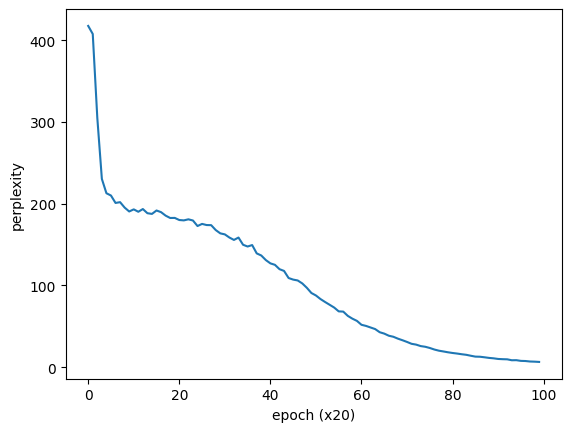

In [7]:
trainer.plot()

RNN 활성화 함수 변경

In [16]:
# coding: utf-8
from common.np import *  # import numpy as np (or import cupy as np)
from common.layers import *
from common.functions import sigmoid

def relu(x):
    return np.maximum(0, x)

class RNNRelu:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b
        h_next = relu(t)

        self.cache = (x, h_prev, h_next)
        return h_next

    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache

        dt = dh_next * (h_next > 0)

        db = np.sum(dt, axis=0)
        dWh = np.dot(h_prev.T, dt)
        dh_prev = np.dot(dt, Wh.T)
        dWx = np.dot(x.T, dt)
        dx = np.dot(dt, Wx.T)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        return dx, dh_prev


class TimeRNNRelu:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.dh = None, None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = RNNRelu(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape

        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)
            dxs[:, t, :] = dx

            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh

        return dxs

    def set_state(self, h):
        self.h = h

    def reset_state(self):
        self.h = None

In [17]:
import numpy as np
from common.time_layers import *

class SimpleRnnlmRelu:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V,D) / 100).astype('f')
        rnn_Wx = (rn(D,H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H,H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H,V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNNRelu(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layers = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
    
    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layers.forward(xs, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layers.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.rnn_layer.reset_state()

In [18]:
model = SimpleRnnlmRelu(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer_relu = RnnlmTrainer(model, optimizer)

trainer_relu.fit(xs, ts, max_epoch, batch_size, time_size)

| 에폭 1 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 418.02
| 에폭 2 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 409.04
| 에폭 3 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 387.54
| 에폭 4 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 319.33
| 에폭 5 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 254.95
| 에폭 6 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 262.71
| 에폭 7 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 228.91
| 에폭 8 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 218.35
| 에폭 9 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 221.22
| 에폭 10 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 199.22
| 에폭 11 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 201.15
| 에폭 12 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 195.98
| 에폭 13 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 201.58
| 에폭 14 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 194.44
| 에폭 15 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 199.87
| 에폭 16 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 196.99
| 에폭 17 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 194.22
| 에폭 18 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 189.10
| 에폭 19 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 185.88
| 에폭 20 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 185.93
| 에폭 21 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 184.90
| 에폭 22 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 182.

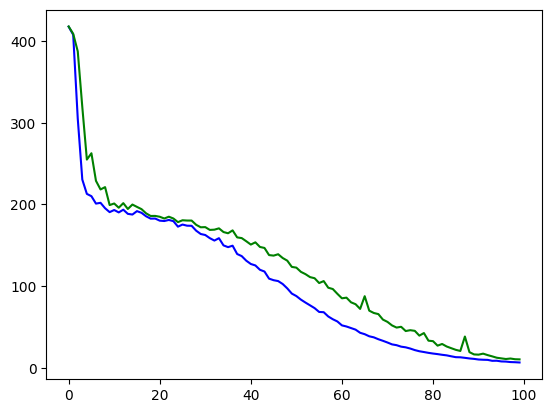

In [22]:

x = np.arange(len(trainer.ppl_list))
plt.plot(x, trainer.ppl_list, label='tanh', color='blue')
plt.plot(x, trainer_relu.ppl_list, label='relu', color='green')